In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# import seaborn as sns
import scipy
import importlib
import sys
import torch
import pandas as pd
import os
import reservoir as rdl
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from recover.utils.utils import get_tensor_dataset
import seaborn as sns
from tqdm import tqdm
import numpy as np
import json
from copy import deepcopy
# sns.set_theme()
sns.set_style("ticks")

In [2]:
#####################################
# Methods to get different types of loaders
#####################################


def get_regular_valid_loader(trainer):
    return trainer.valid_loader

def get_test_loader(trainer):
    test_dataset = get_tensor_dataset(trainer.data, trainer.test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

#####################################
# Iterator over trainers for a given config
#####################################

def trainer_iterator(config_file, path_to_conf):
    configuration = importlib.import_module("recover.config." + config_file).configuration

    # Loop over all runs for this configuration
    for run_dir in tqdm(os.listdir(os.path.join(path_to_conf, config_file))):
        print(run_dir)
        if run_dir.startswith('BasicTrainer'):

            this_run_results = {}

            # Load params for that run
            with open(os.path.join(path_to_conf, config_file, run_dir, 'params.json')) as f:
                params = json.load(f)

            # Load configuration (can contain grid_search args)
            this_run_config = deepcopy(configuration)

            # Replace grid_search args by the actual parameter for that run
            for key in this_run_config['trainer_config']:
                if type(this_run_config['trainer_config'][key]) is dict \
                and 'grid_search' in this_run_config['trainer_config'][key].keys():
                    
                    # If grid search over python classes, we need to load them
                    if type(params[key]) is str and params[key].startswith('<class'):
                        class_to_load = params[key]
                        class_to_load = class_to_load.split("'")[1]
                        class_to_load = class_to_load.rpartition('.')
                        path_to_class = class_to_load[0]
                        class_to_load_name = class_to_load[-1]
                        params[key] = getattr(importlib.import_module(path_to_class), 
                                              class_to_load_name)
                    this_run_config['trainer_config'][key] = params[key]
                    this_run_results[key] = params[key]

            # Load trainer
            trainer = this_run_config["trainer"](this_run_config["trainer_config"])

            # Find the checkpoint corresponding to the best epoch (always two checkpoints, 
            # corresponding to best and last epochs)
            cpt = 0
            checkpoint = None
            for dir_check in os.listdir(os.path.join(path_to_conf, config_file, run_dir)):
                if dir_check.startswith('checkpoint'):
                    cpt += 1
                    if checkpoint is None:
                        checkpoint = dir_check
                    else:
                        if int(dir_check.split('_')[-1]) < int(checkpoint.split('_')[-1]):
                            checkpoint = dir_check
                            
            if cpt == 2:
                # Only yield trainer if 2 checkpoints have been saved (corresponding to best and last epochs)

                # Load model
                trainer.model.load_state_dict(torch.load(path_to_conf + config_file + "/" + 
                                                 run_dir + "/" + checkpoint + "/model.pth",
                                                 map_location=torch.device('cpu')))
                print("Loaded model from", run_dir, checkpoint)
                
                yield trainer

#####################################
# Method to get the proportion of synergistic combos in query
#####################################

def compute_proportion_synergistic_in_query(config_file, path_to_conf, get_eval_loader=get_regular_valid_loader):
    all_results_df = None
    all_true_proportion_above_thresh = []

    for trainer in trainer_iterator(config_file, path_to_conf):
        eval_loader = get_eval_loader(trainer)

        all_out = []
        all_ground_truth = []
        with torch.no_grad():
            for _, drug_drug_batch in enumerate(eval_loader):
                output = trainer.model.forward(trainer.data, drug_drug_batch)
                truth = drug_drug_batch[2]
                all_out.append(output.squeeze())
                all_ground_truth.append(truth)
        all_out = torch.cat(all_out).to("cpu")
        all_ground_truth = torch.cat(all_ground_truth).to("cpu")

        # Compute true proportion of highly synergistic combinations in the whole test set
        true_syn_thres = 30
        true_proportion_above_thresh = float((all_ground_truth > true_syn_thres).sum() / \
                                             float(len(all_ground_truth)))
        print("proportion of combos with synergy above " + str(true_syn_thres) +" in the whole \
        test set:", true_proportion_above_thresh)
        all_true_proportion_above_thresh.append(true_proportion_above_thresh)

        ordered_preds = all_out.sort().indices

        # Compute proportion of highly synergistic combinations in query, for all query sizes 
        # between 5 and 100.
        res = []
        for n in range(5, 100):
            true_synergies_of_predicted_top_n = all_ground_truth[ordered_preds[-n:]].numpy() 
            prop_above_thresh = (true_synergies_of_predicted_top_n > true_syn_thres).sum() / n
            res.append(prop_above_thresh)

        results_df = pd.DataFrame([range(5, 100), res]).T
        results_df.columns = ["Size of the query", "% of synergistic combos in the query"]

        if all_results_df is None:
            all_results_df = results_df
        else:
            all_results_df = pd.concat((all_results_df, results_df))

    all_results_df = all_results_df.reset_index(drop=True)
        
    return all_results_df, np.mean(all_true_proportion_above_thresh)

## Default task

In [3]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="model_evaluation", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_regular_valid_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


In [4]:
all_results_df = all_results_df.rename(columns={"% of synergistic combos in the query": 
                                          "% of synergistic combinations"})

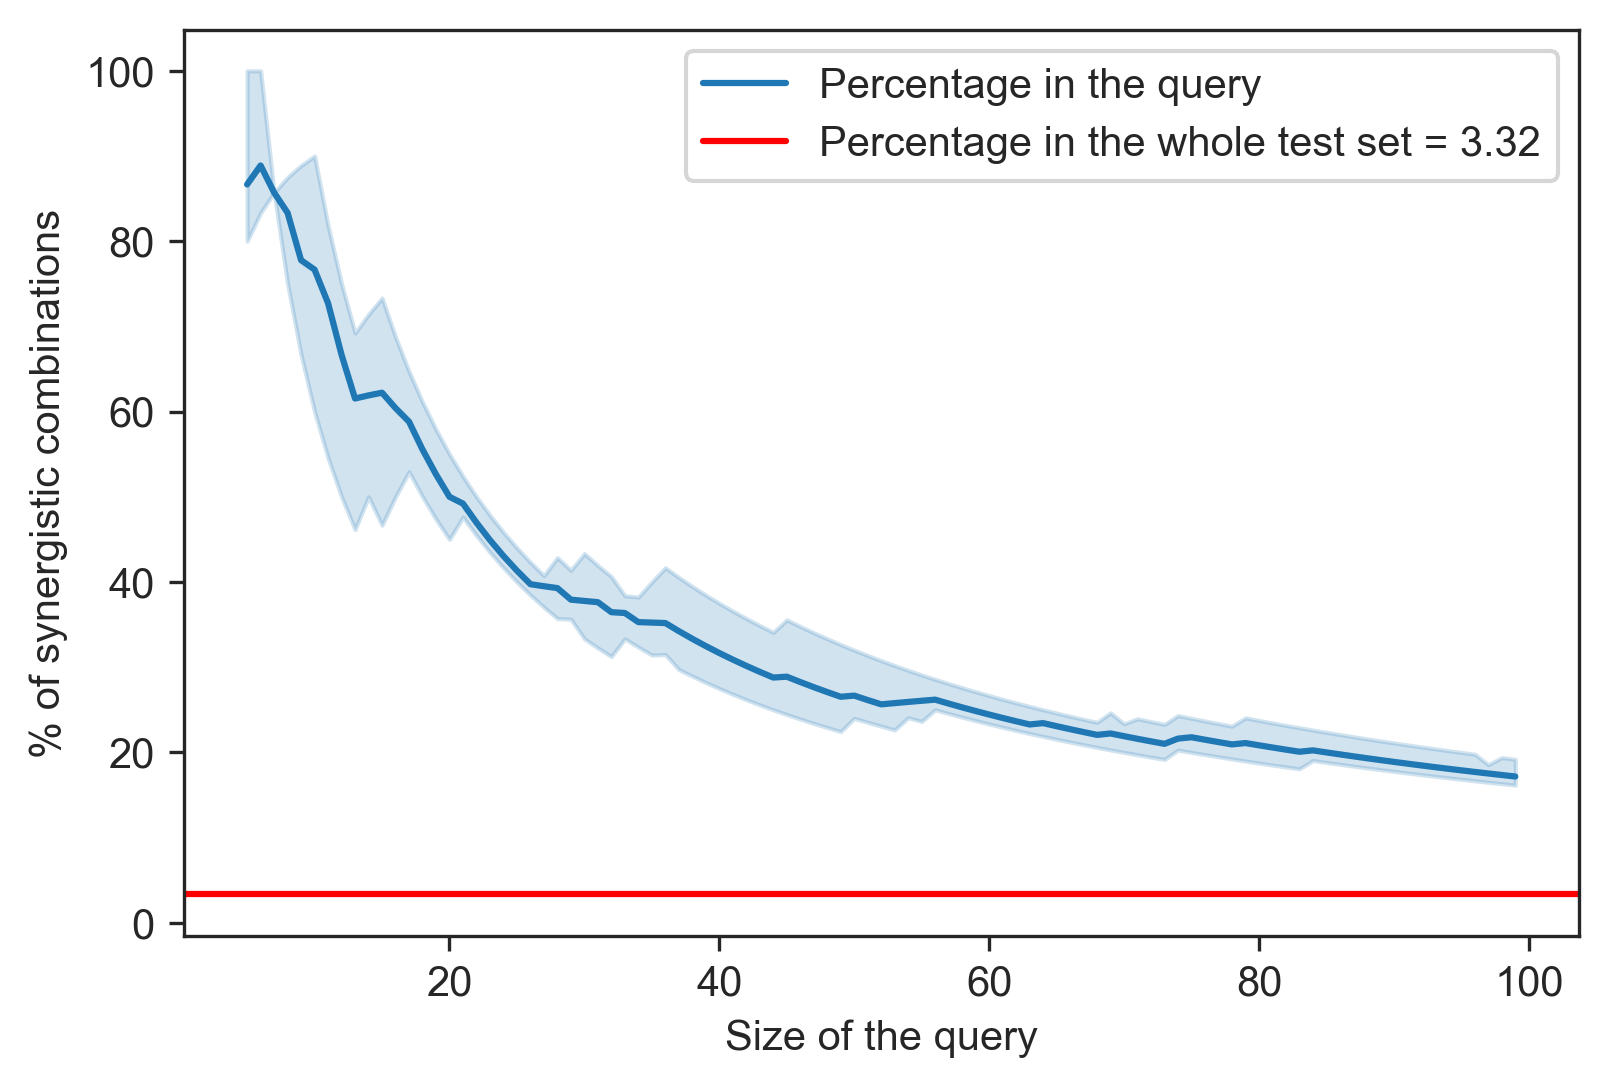

In [5]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combinations", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

In [6]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="model_evaluation", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_test_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 6/6 [00:00<00:00,  7.43it/s]


In [7]:
all_results_df = all_results_df.rename(columns={"% of synergistic combos in the query": 
                                          "% of synergistic combinations"})

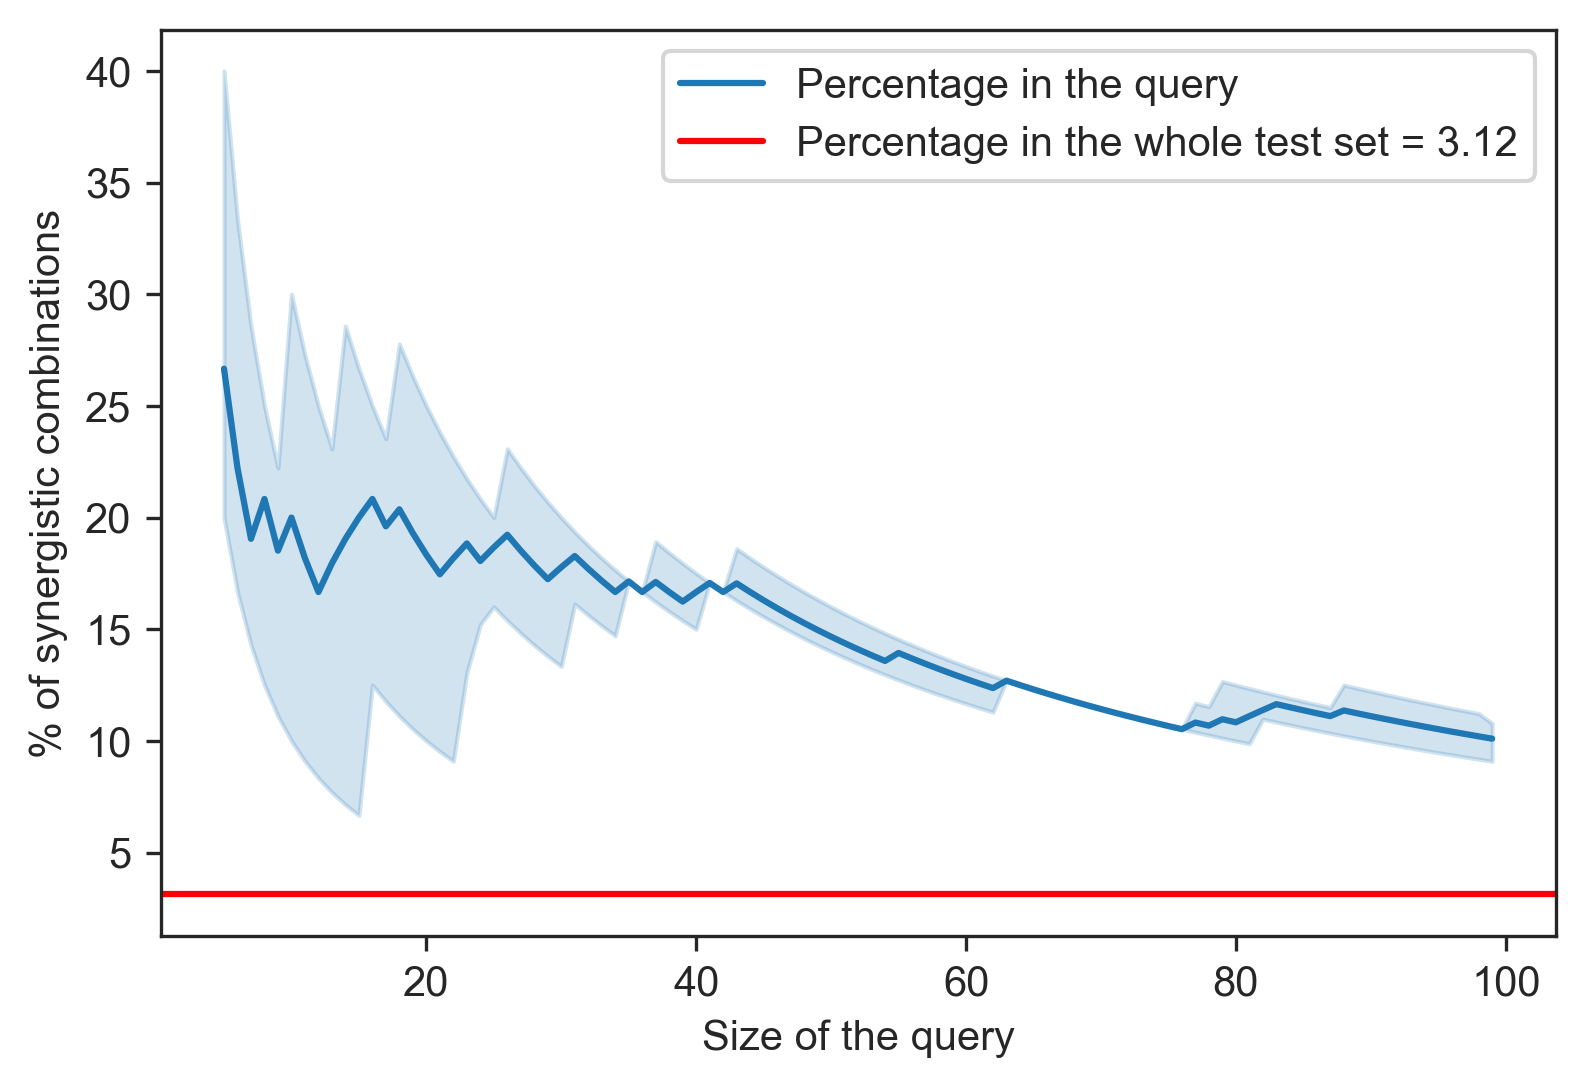

In [8]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combinations", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

## Drug Level Split

In [9]:
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixDrugLevelSplitTest

def get_drug_split_test_loader(trainer):
    
    dl_split_data = DrugCombMatrixDrugLevelSplitTest(cell_line='MCF7',
                                     fp_bits=1024,
                                     fp_radius=2)
    dl_split_data.data.ddi_edge_response = dl_split_data.data.ddi_edge_bliss_max
    
    test_idxs = range(len(dl_split_data.data.ddi_edge_response))
    
    test_dataset = get_tensor_dataset(dl_split_data.data, test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

In [10]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="model_drug_level_split", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_regular_valid_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


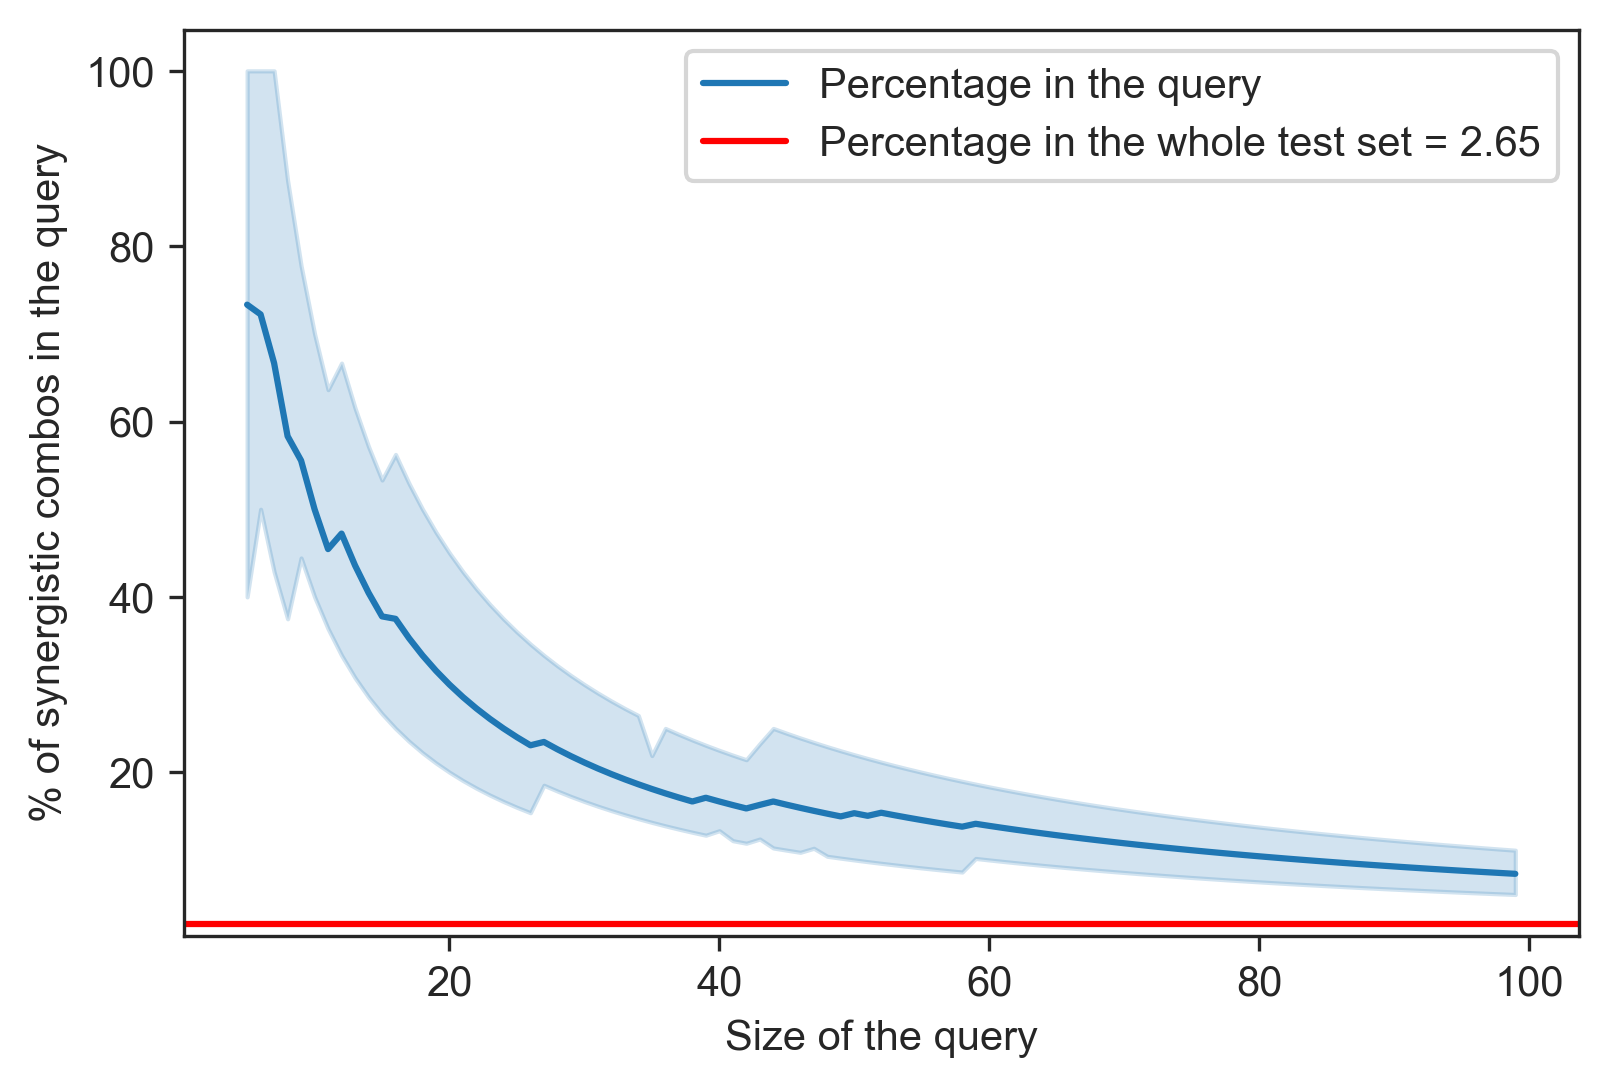

In [11]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combos in the query", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

In [12]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="model_drug_level_split", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_drug_split_test_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


In [13]:
all_results_df = all_results_df.rename(columns={"% of synergistic combos in the query": 
                                          "% of synergistic combinations"})

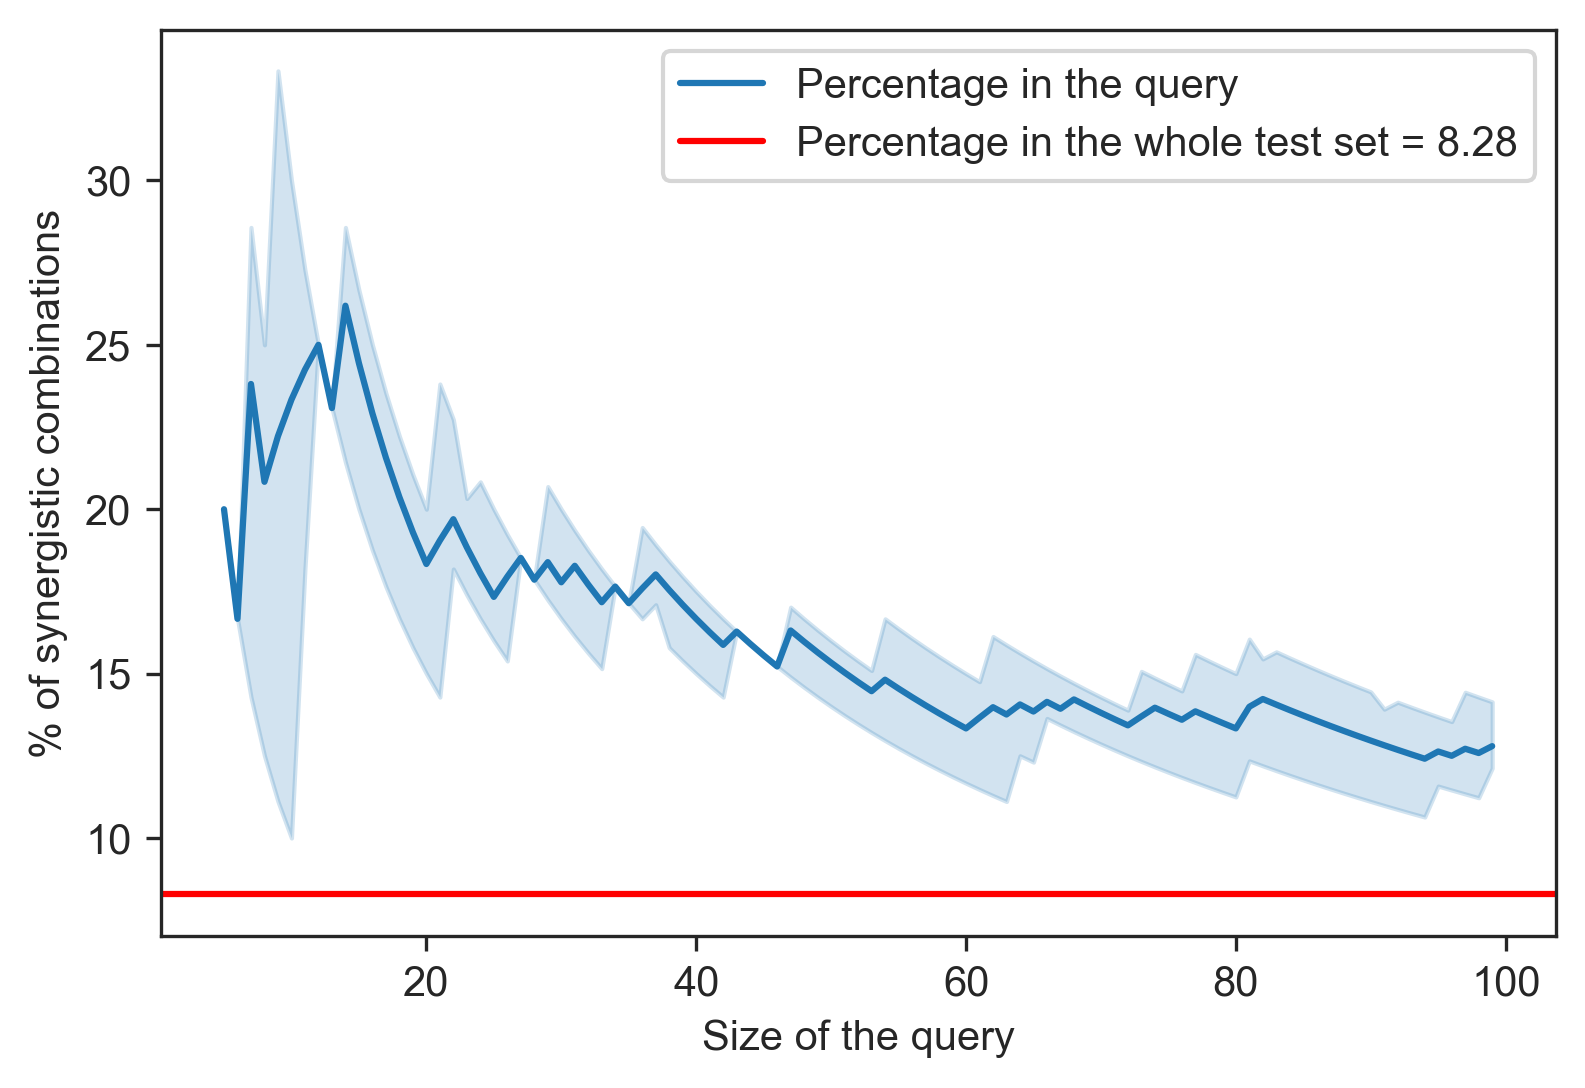

In [14]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combinations", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

## Multi Cell Line

In [15]:
def get_mcf7_test_loader(trainer):

    mcf7_idxs = np.where(np.array(trainer.data.ddi_edge_classes) == trainer.data.cell_line_to_idx_dict['MCF7'])[0]
    
    mcf7_test_idxs = list(set(np.array(trainer.test_idxs)).intersection(mcf7_idxs))
    mcf7_test_idxs = torch.Tensor(mcf7_test_idxs).long()

    test_dataset = get_tensor_dataset(trainer.data, mcf7_test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

In [16]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="model_evaluation_multi_cell_line", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_mcf7_test_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


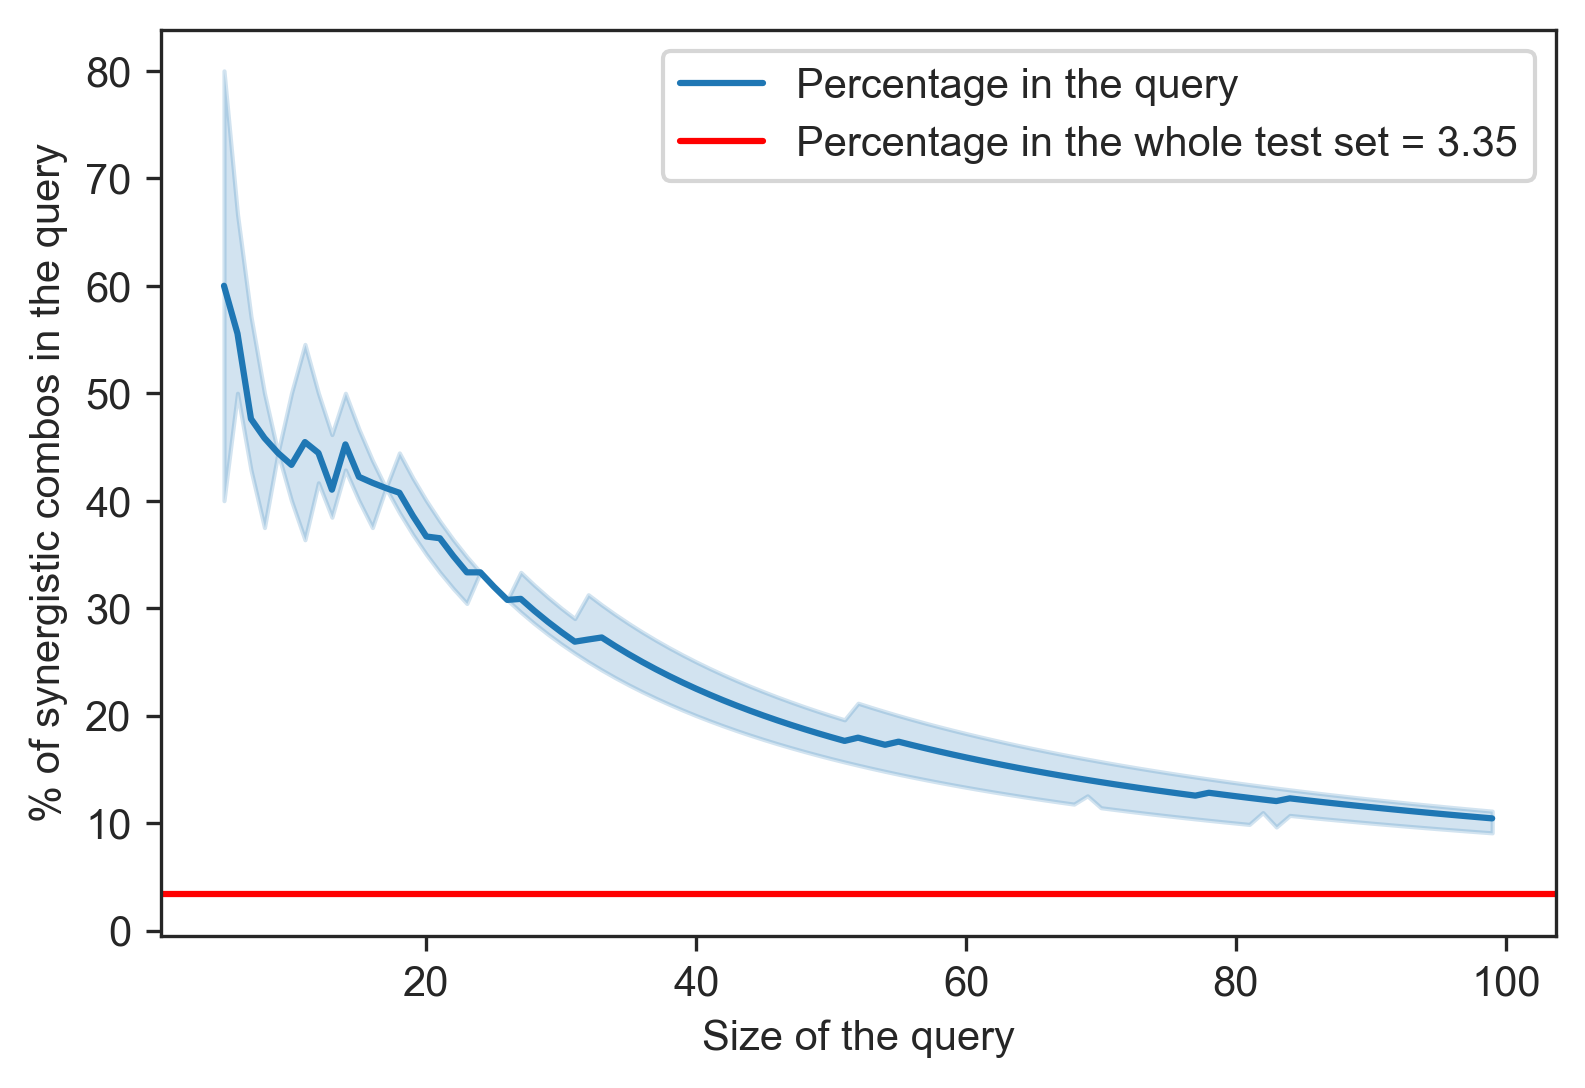

In [17]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combos in the query", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

## Cell Line Transfer

In [18]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="cell_line_transfer", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_test_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 6/6 [01:27<00:00, 14.65s/it]


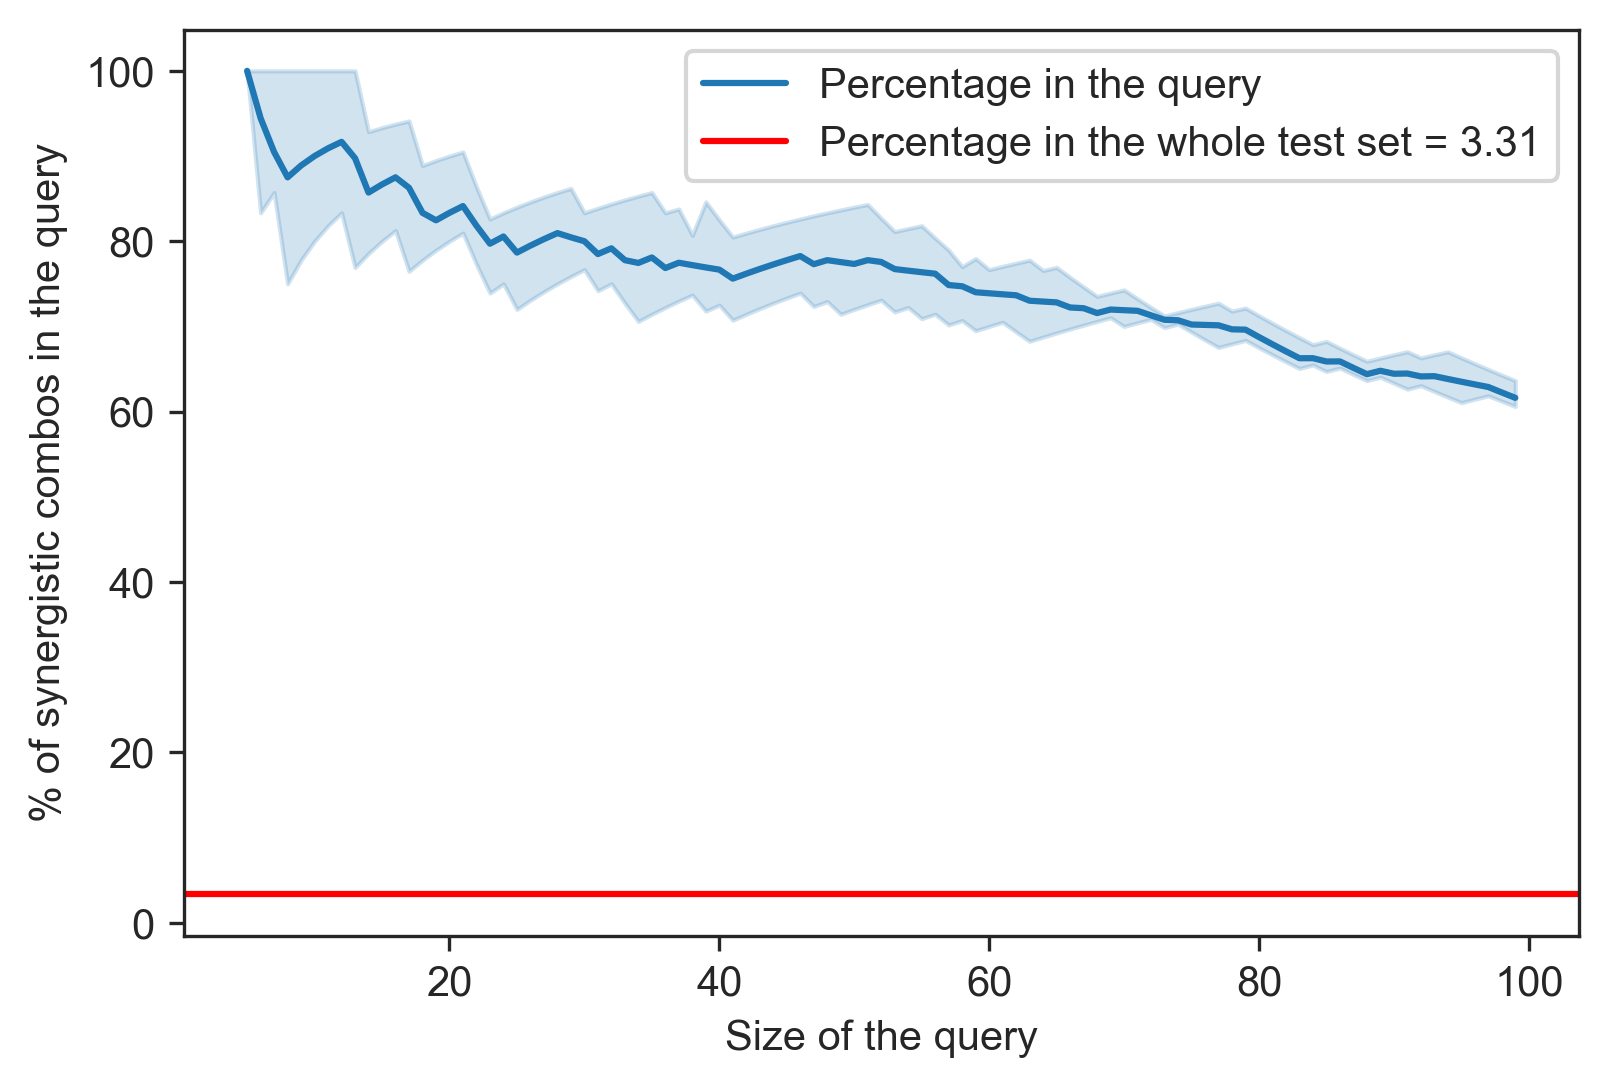

In [19]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combos in the query", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()

## Study Transfer

In [20]:
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixTestAlmanac

def get_trimmed_Almanac_test_loader(trainer):
    
    dl_split_data = DrugCombMatrixTestAlmanac(cell_line=None,
                                     fp_bits=1024,
                                     fp_radius=2)
    dl_split_data.data.ddi_edge_response = dl_split_data.data.ddi_edge_bliss_max
    
    test_idxs = range(len(dl_split_data.data.ddi_edge_response))
    
    test_dataset = get_tensor_dataset(dl_split_data.data, test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

In [21]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results_df, true_proportion_above_thresh = compute_proportion_synergistic_in_query(
    config_file="pretrain_ONEIL", 
    path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/",
    get_eval_loader=get_trimmed_Almanac_test_loader)

sys.stdout = old_stdout # reset old stdout

all_results_df["% of synergistic combos in the query"] = all_results_df["% of synergistic combos in the query"].\
    apply(lambda x: 100*x) 

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


In [22]:
all_results_df = all_results_df.rename(columns={"% of synergistic combos in the query": 
                                          "% of synergistic combinations"})

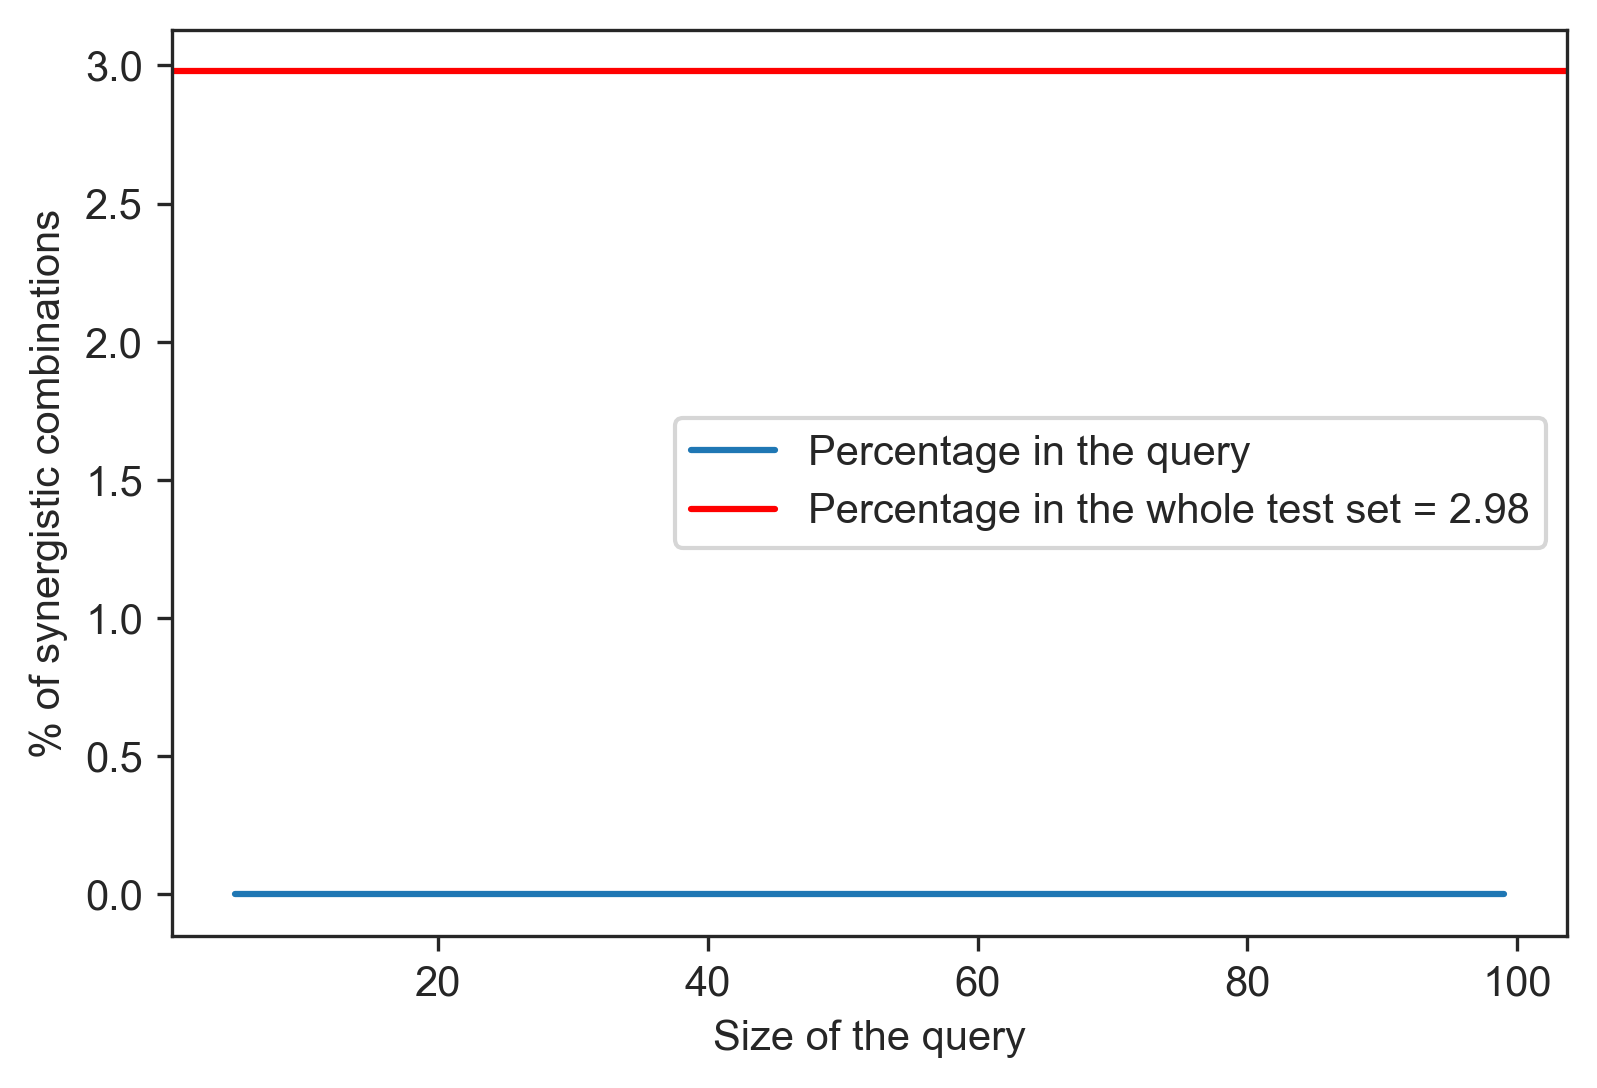

In [23]:
plt.figure(dpi=300)
sns.lineplot(data=all_results_df, x="Size of the query", 
             y="% of synergistic combinations", label="Percentage in the query")
plt.axhline(y=100*true_proportion_above_thresh, 
            color='r', 
            linestyle='-', 
            label="Percentage in the whole test set = " + str(100*true_proportion_above_thresh)[:4])
plt.legend()
# plt.ylim(0, 0.42)
plt.show()